# In which I implement Linear Regression on a sample data set from Andrew Ng's Machine Learning Course.

Week 2 of Andrew Ng's ML course on Coursera focuses on doing linear regression with the common squared error cost function, using gradient descent for the actual fitting (remember to scale features!), and alternatively using the Normal Equation analytical solution. Here I use the homework data set to learn about the relevant python tools.

>## Tools Covered:
- `SGDRegressor` for general linear model regression specifying a loss and penalty
- `LinearRegression` for normal equation solution to least squares loss linear regression
- `mean_squared_error` for computing this super common loss metric
- `StandardScaler` for feature scaling your data
- also Surface Plots and Contour Plots in `matplotlib`


# Visualizing the Data
*Suppose you are the CEO of a restaurant franchise and are considering different cities for opening a new outlet. The chain already has trucks in various cities and you have data for profits and populations from the cities. You would like to use this data to help you select which city to expand to next. The file `ex1data1.txt` contains the dataset for our linear regression problem. The first column is the population of a city and the second column is the profit of a food truck in that city. A negative value for profit indicates a loss.*

*Before starting on any task, it is often useful to understand the data by visualizing it. For this dataset, you can use a scatter plot to visualize the data, since it has only two properties to plot (profit and population). (Many other problems that you will encounter in real life are multi-dimensional and can't be plotted on a 2-d plot.)*

In [0]:
#!pip install snips

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import snips as snp

In [0]:
#cd hw-wk2

In [17]:
df = pd.read_csv("https://raw.githubusercontent.com/Gurubux/StatQuest/master/GradientDescent/ex1data1.txt", header=None)
df.columns = ["popn", "profit"]
df.head()

,popn,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


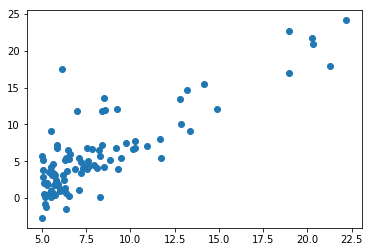

In [18]:
fig, ax = plt.subplots()
ax.scatter(df["popn"], df["profit"])

#snp.labs("population", "profit", "Initial Visualization")

There is obviously a strong positive relationship which looks roughly linear though with a lot of scatter. There shouldn't be any need for feature scaling as both population and profit are reported in units that put them in the "tens" range.

# Linear Regression With One Variable

## Gradient Descent
*In this part, you will fit the linear regression parameters to our dataset using gradient descent.*

[According to the documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) `scikit-learn`'s standard linear regression object is actually just a piece of code from `scipy` which is wrapped to give a predictor object. The aforementioned `scipy` function is **[`scipy.linalg.lstsq`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html) which just uses the Normal equation to compute the minimizer analytically**, and will give you an warning if the relevant matrix is non-invertible! This is interesting as Andrew mentioned the normal equation almost as an afterthought to gradient descent as far as implementing a real algorithm for doing linear regression, but it seems in the real world the default method is perhaps the normal equation.   


### Stochastic versus Batch Gradient Descent
**If you really want to get gradient descent in `scikit-learn` then the relevant object is called `SGDRegressor`** (or for classification problems `SGDClassifier` - recall classification is where your labels are discrete category-like). The "SGD" stands for *stochastic* gradient descent, so it's not quite the same as what Andrew covers in his class, although he does discuss it in the real [Stanford CS299 notes](http://cs229.stanford.edu/notes/cs229-notes1.pdf). On Coursera he mentions that using every data point in your training example to compute $\frac{\partial J}{\partial \theta_j}$ at every iteration of GD is called **batch gradient descent**, but he doesn't detail the alternatives, one of which is **stochastic gradient descent**. So allow me to quote from his real class notes:
> In [stochastic gradient descent], we repeatedly run through the training set, and each time
we encounter a training example, we update the parameters according to
the gradient of the error with respect to that single training example only.

According to [this SO answer](http://stackoverflow.com/questions/34469237/linear-regression-and-gradient-descent-in-scikit-learn-pandas) batch gradient descent is not often used in practice:
>If you can decompose your loss function into additive terms, then stochastic approach is known to behave better... and if you can spare enough memory - OLS method is faster and easier. 

And for further reading on the difference between *batch* versus *stochastic* check out [this quora question](https://www.quora.com/Whats-the-difference-between-gradient-descent-and-stochastic-gradient-descent).

### Tools in `sklearn` for Stochastic Gradient Descent
With the `SGDRegressor` object you need to explicitly set your cost function to be squared error and tell it not to use any "penalty" (which Andrew hasn't discussed yet, but is essentially another way to influence the specific hypothesis which the ML algorithm returns). 

From the official documentation of `scikit-learn`:

>Stochastic gradient descent is a simple yet very efficient approach to fit linear models. It is particularly useful when the number of samples (and the number of features) is very large. The classes SGDClassifier and SGDRegressor provide functionality to fit linear models for classification and regression using different (convex) loss functions and different penalties. E.g., with loss="log", SGDClassifier fits a logistic regression model...


The [official documention page for `SGD`](http://scikit-learn.org/stable/modules/sgd.html#sgd) is excellent and very clear. As mentioned above, this is a more general linear regression fitting object, so below I will outlineusing it with a focus on using it with squared error cost and using this HW data set as an example. 

First we need to instantiate the fitting object, telling it what our cost function AKA loss function is - in our case cost is squared error. We could also instantiate it with a penalty function here, but we're not using those so instead we set `None` since the default is actually `L2` penalty or "regularization" (don't worry about it for now).

In [0]:
from sklearn.linear_model import SGDRegressor

# Create an SGDClassifier instance which will have methods to do our linear regression fitting by gradient descent
fitter = SGDRegressor(loss="squared_loss", penalty=None)

To do a fitting, the SGDClassifier object will want to see an array, $X$, holding your table of features for the training set, as well as a vector, $y$, holding the label i.e. y-value for each element of the training set. From our HW data set:

In [20]:
X = df.as_matrix(columns=["popn"])  # SGDRegressor is very particular on input "X" and insists on a true matrix 
y = df["profit"].tolist() # This is the variable we want to predict, SGDRegressor expects a vector-like object

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


*[A quick but important aside: in class when Andrew writes $X$ for the data matrix he usually means this to include a column of all ones for $\theta_0$ (the intercept term). When using all these lovely `sklearn` tools it's not necessary to include this column explicitly in your $X$, it will be created for you.]*

Now we actually do the fit AKA execute the gradient descent by calling a method of our `SGDRegressor` object. Note that calling this method will not return anything to do with the fit, but rather all the fitting information will be stored as attributes of the object. 

In [21]:
fitter.fit(X, y)  # Do the fit by calling a method of our object

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

You might see some names that seem to correspond with Andrew's lectures such as `alpha` and `epsilon`. But actually `SGDRegressor` is just messing with you and all of these have different meanings from what Andrew talked about. Here's a couple "gotchas". Also this guy is implemented as a pretty high-level tool so it doesn't expose all the innards of the gradient descent is just performed. This means we can't, for example, plot the cost function $J$ as a function of number of iterations.

At any rate, the fit is done and we can call the `predict` method of the fittng object to actually use the selected hypothesis in predicting new data. For instance:

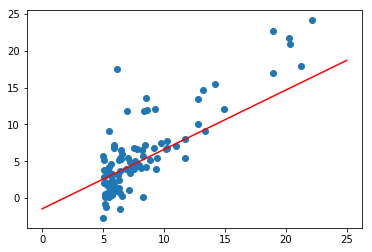

In [22]:
xs = list(range(0, 26, 1))
xs = np.array(xs).reshape(-1, 1)

new_ys = fitter.predict(xs)

fig, ax = plt.subplots()
ax.scatter(df["popn"], df["profit"])
#snp.labs("population", "profit", "Data vs. Linear Regression Gradient Descent Fit")
ax.plot(xs, new_ys, color="red")

### Why Does it Suck Out of the Box?
By eye I'd say this did kind of a poopy job and a slightly smaller intercept with a slightly larger positive slope would improve 
our fit. What is the reason for this crappiness?  Well, [this SE](http://datascience.stackexchange.com/questions/6676/scikit-learn-getting-sgdclassifier-to-predict-as-well-as-a-logistic-regression) answer where someone ran into the same issue was super helpful in troubleshoting. It turns out [a good rule of thumb](http://scikit-learn.org/stable/modules/sgd.html#tips-on-practical-use) for the number of passes over the training set is `n_iter = np.ceil(10**6 / n)` to get convergence. Let's try it out:

In [23]:
fitter.n_iter = np.ceil(10**6 / len(y))
fitter.fit(X, y)  # Do the fit by calling a method of our object

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

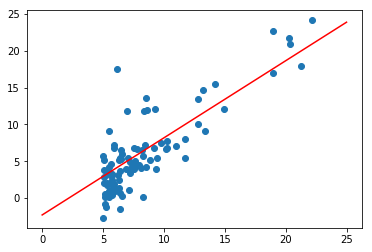

In [24]:
xs = list(range(0, 26, 1))
xs = np.array(xs).reshape(-1, 1)

new_ys = fitter.predict(xs)

fig, ax = plt.subplots()
ax.scatter(df["popn"], df["profit"])
#snp.labs("population", "profit", "Data vs. Linear Regression Gradient Descent Fit")
ax.plot(xs, new_ys, color="red")

Yep, it looks like that was the problem. Using the default settings it was stopping the algorithm after only `n_iter = 5` runs through the full training set, which for this data set amounts to only 500 steps rather than the recommended 1 million!

### Comparison to Normal Method
For the sake of comparison, let's see how the normal equation method would do. Recall that the most commonly used linear regression tool in `sklearn` is the `LinearRegression` object, and it is actually using the normal method. The architecture of this class is super similar to what we just used with `SGDRegressor`:

In [25]:
from sklearn.linear_model import LinearRegression
norm_eqn = LinearRegression()
norm_eqn.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

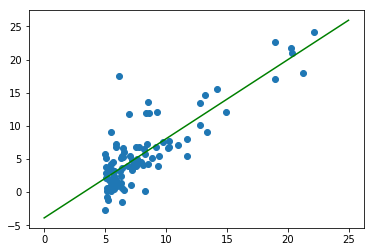

In [26]:
new_ys = norm_eqn.predict(xs)

fig, ax = plt.subplots()
ax.scatter(df["popn"], df["profit"])
#snp.labs("population", "profit", "Data vs. Linear Regression Gradient Descent Fit")
ax.plot(xs, new_ys, color="green")

Yeah, that's quite good and agrees pretty well with the optimized SGD.

### Feature Scaling
As a sidenote, SGD is sensitive to feature scaling just like batch GD, so when needed you get to use [this super nifty toy](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html):

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

This guy has has `fit` method which, rather than fitting a model in the conventional sense, instead computes and saves the sample mean and variance for each feature in your input matrix `X` and then uses those values to drive it's `transform` method on any data you feed it. That is you `fit` your transformer object with your training data, and then of course `transform` that same data and any future data points you might have before feeding into your ML algorithm of choice.

In [0]:
scaler.fit(X)  # Train the transformer object so it knows what means and variances to use
X_transformed = scaler.transform(X)  # transform your training data in preparation for some badass ML algorithm

In [29]:
X[0], X_transformed[0]  # An example of the transformation.

(array([6.1101]), array([-0.53240565]))

## Visualizing The Cost Function
*To understand the cost function $J(\theta)$ better, you will now plot the cost over
a 2-dimensional grid of $\theta_0$ and $\theta_1$ values.*

We'll need to code the linear model, but to actually calculate the sum of squared errors (least squares loss) we can borrow a piece of code from `sklearn`:

In [0]:
from sklearn.metrics import mean_squared_error as mse

In [0]:
xvals = df["popn"]
yvals = df["profit"]
def predict_y(thetas, xs):
    ''' Predict y from a first order linear model in x.'''
    ys = thetas[0] + thetas[1]*xs
    return ys

Check out [this](http://stackoverflow.com/a/9170879/4639070) excellent stack overflow answer for a quick example of surface plots in matplotlib. We're basically copy/pasting what that guy did. The `meshgrid` function takes two vectors and sort of creates the space of that is their outer product. It is returning a matrix for $\theta_0$ which tells us at each point on a grid (outer product) the value it takes - and the same kind of matrix for $\theta_1$.

In [0]:
th0 = np.arange(-15.0, 15.0, 0.5)
th1 = np.arange(-1, 5, 0.5)
TH0, TH1 = np.meshgrid(th0, th1)

In [0]:
Js = np.array([mse(yvals, predict_y([th0, th1], xvals)) for th0, th1 in zip(np.ravel(TH0), np.ravel(TH1))])
Js = Js.reshape(TH0.shape)

Text(0.5, 0, 'J')

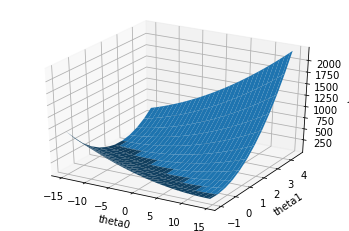

In [36]:
#from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(TH0, TH1, Js)
ax.set_xlabel("theta0")
ax.set_ylabel("theta1")
ax.set_zlabel("J")

Text(0.5, 1.0, 'Simplest default with labels')

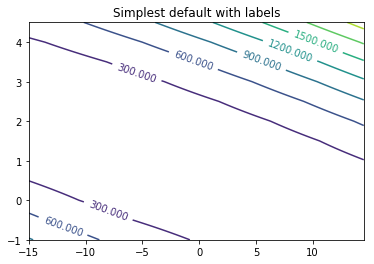

In [35]:
plt.figure()
CS = plt.contour(TH0, TH1, Js)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Simplest default with labels')

# Summary
Linear Regression to fit the typical linear hypothesis form can be done with `SGDRegressor` wherein you specify the specific loss function and penalty and it uses stochastic gradient descent (SGD) to do the fitting. In SGD you repeatedly run through the training set one data point at a a time and update the parameters according to the gradient of the error with respect to each individual data point. Be sure to set the $n_{\textrm{iter}}$ parameter high enough to get good convergence. The class `LinearRegression` is less general and always uses the least squares loss, and it uses the analtical Normal Equation method for solving the fit. In all cases the tool `StandardScaler` automates the feature scaling (by mean and variance) for you.